In [1]:
from pathlib import Path
import math
from tqdm import tqdm
from typing import Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import nvdiffrast.torch as dr

from extension import utils, ops_3d, Mesh
from semantic_sam import semantic_sam_l
from segment_anything import build_sam_vit_h, SamPredictor
from tree_segmentation import TreePredictor, TreeData, MaskData, Tree3D
from tree_segmentation.tree_3d import TreeSegment
from tree_segmentation.util import show_masks, image_add_points, image_add_mask_boundary

2023-07-19 15:23:52.947186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 15:23:53.981818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-07-19 15:23:53.981944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline
utils.set_printoptions(precision=6)
device = torch.device('cuda')

In [3]:
# load SAM
sam_pth = Path('~/models/segmentation/sam_vit_h_4b8939.pth').expanduser()
sam = build_sam_vit_h(sam_pth).to(device)
tree_seg = TreePredictor(sam, box_nms_thresh=0.7)

In [3]:
semantic_sam_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
semantic_sam = semantic_sam_l(semantic_sam_path).eval().cuda()
tree_seg2 = TreePredictor(semantic_sam, box_nms_thresh=0.7, image_size=1024)

/home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Do not load pretrained models


# 2D Tree Segmentation

numpy((800, 800, 4), uint8)


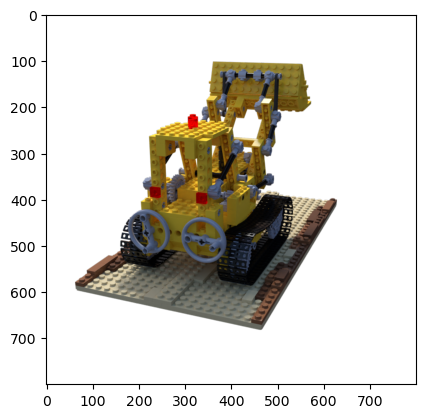

In [4]:
# load pictures
img_path = Path('~/data/NeRF/synthetic/lego/train/r_1.png').expanduser()
image = utils.load_image(img_path)
H, W = image.shape[:2]
# predictor.set_image(image[..., :3])
print(utils.show_shape(image))
plt.imshow(image)

In [6]:
tree_data = tree_seg.generate(
    image[..., :3],
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)

iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]
iou_predictions, low_res_masks: F32Tensor[64, 3], F32Tensor[64, 3, 256, 256]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 tree_data = tree_seg.generate(                                                              │
│    2 │   image[..., :3],                                                                         │
│    3 │   max_iters=100,                                                                          │
│    4 │   in_threshold=0.9,                                                                       │
│                                                                                                  │
│ /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/torch/utils/_contextlib.py:115 in      │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /home/wan/wan_code/segmentation/tree_segmentation/predictor.py:114 in generate                   │
│                                                                                                  │
│   111 │   │   │   new_mask_data = self.process_points(points)                                    │
│   112 │   │   │                                                                                  │
│   113 │   │   │   tree_data.cat(new_mask_data)                                                   │
│ ❱ 114 │   │   │   tree_data.update_tree()                                                        │
│   115 │   │   │   tree_data.remove_not_in_tree()                                                 │
│   116 │   │   │   tree_data.update_tree()                                                        │
│   117                                                                                            │
│                                                                                                  │
│ /home/wan/wan_code/segmentation/tree_segmentation/tree_2d_segmentation.py:326 in update_tree     │
│                                                                                                  │
│   323 │                                                                                          │
│   324 │   def update_tree(self):                                                                 │
│   325 │   │   while self.cnt < len(self.data['masks']):                                          │
│ ❱ 326 │   │   │   self.insert(self.node_new())  # self.print_tree()                              │
│   327 │                                                                                          │
│   328 │   def sample_grid(self, points_per_side=32):                                             │
│   329 │   │   return build_point_grid(points_per_side)                                           │
│                                                                                                  │
│ /home/wan/wan_code/segmentation/tree_segmentation/tree_2d_s

level 1, num=8:


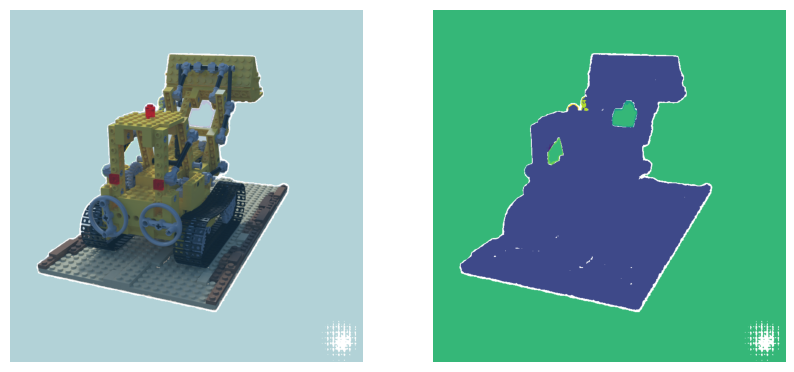

level 2, num=98:


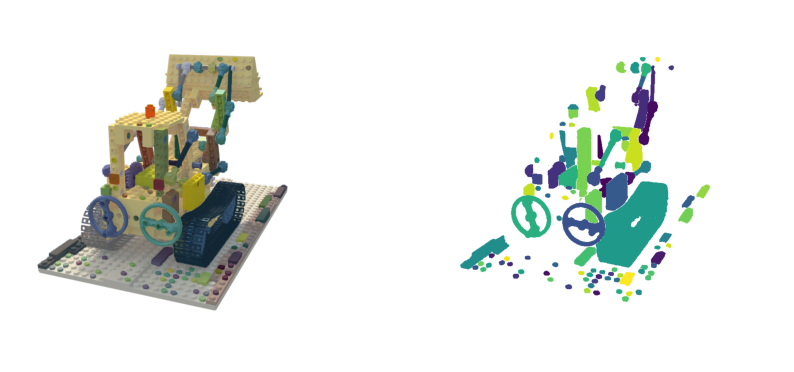

level 3, num=22:


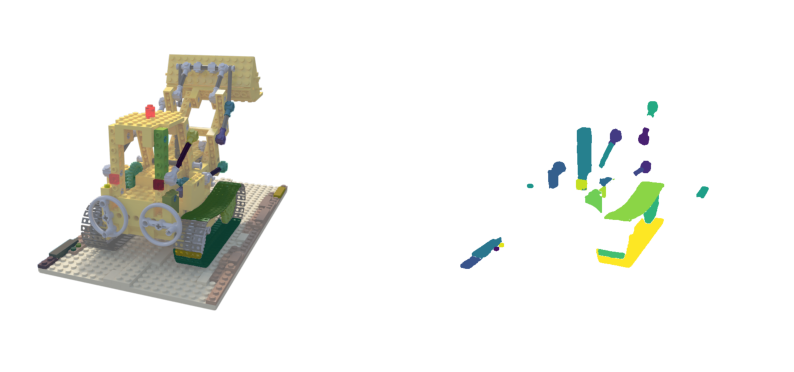

level 4, num=6:


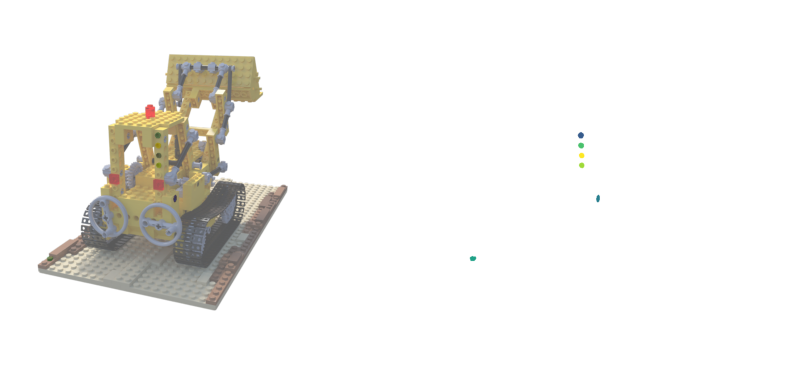

In [7]:
# tree_data.print_tree()
for level, nodes in enumerate(tree_data.get_levels()):
    if level == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {level}, num={len(nodes)}:")
    plt.subplot(121)
    show_masks(image, tree_data.data['masks'][nodes - 1])
    plt.subplot(122)
    show_masks(None, tree_data.data['masks'][nodes - 1])
    plt.show()

complete init segmentation
complete iter 0 update segmentation
complete iter 1 update segmentation
complete iter 2 update segmentation
complete iter 3 update segmentation
complete iter 4 update segmentation
[Tree2D] 161 union with [(31, 0.3746425211429596)]
complete iter 5 update segmentation
complete iter 6 update segmentation
complete iter 7 update segmentation
complete iter 8 update segmentation
complete iter 9 update segmentation
complete iter 10 update segmentation
[Tree2D] 155 union with [(23, 0.6987036466598511)]
complete iter 11 update segmentation
complete iter 12 update segmentation
[Tree2D] 216 union with [(16, 0.20599022507667542), (37, 0.3831579089164734)]
complete iter 13 update segmentation
[Tree2D] 232 union with [(130, 0.22296731173992157)]
complete iter 14 update segmentation
complete iter 15 update segmentation
[Tree2D] 169 union with [(26, 0.6995515823364258)]
complete iter 16 update segmentation
complete iter 17 update segmentation
complete iter 18 update segmentat

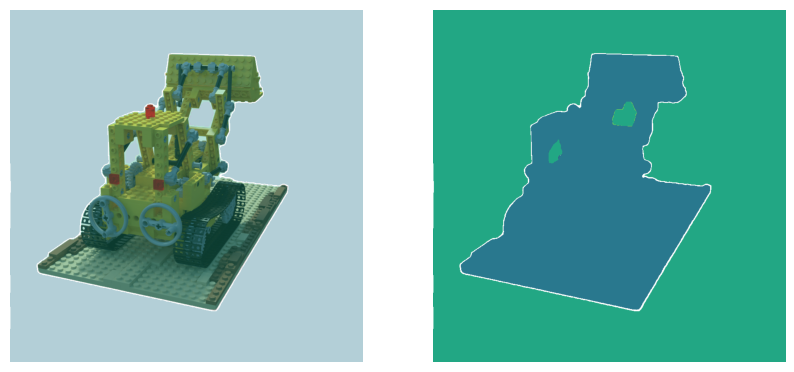

level 2, num=4:


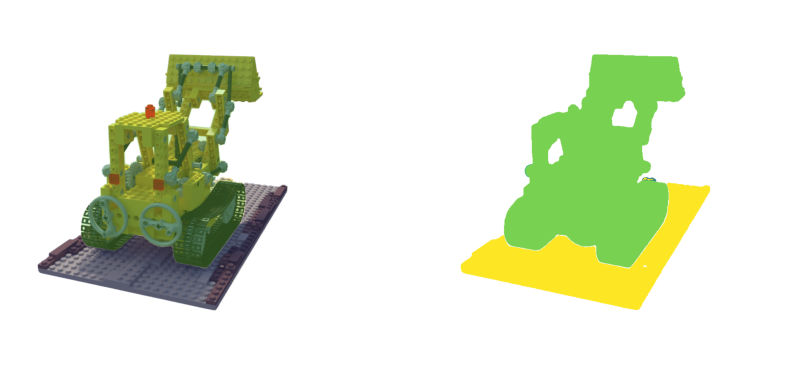

level 3, num=48:


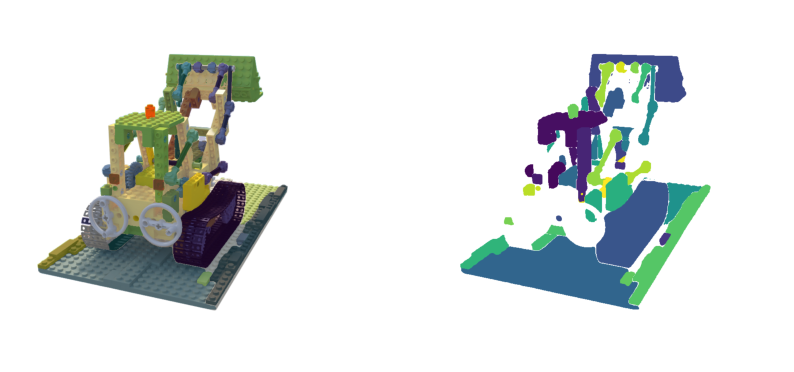

level 4, num=83:


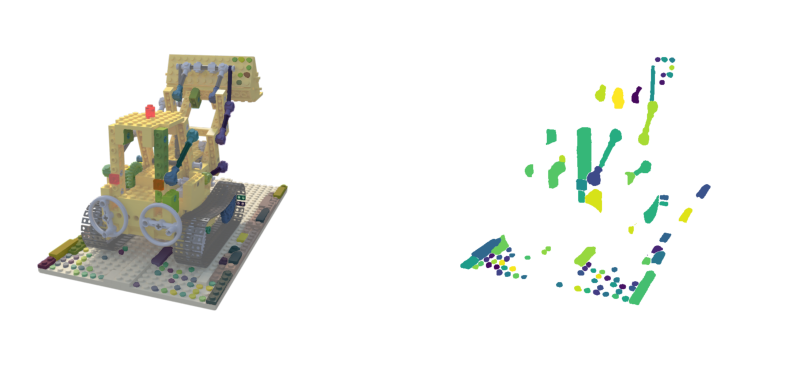

level 5, num=13:


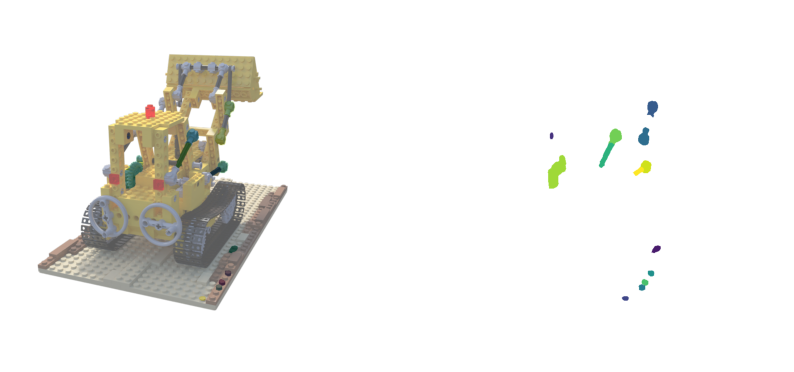

level 6, num=2:


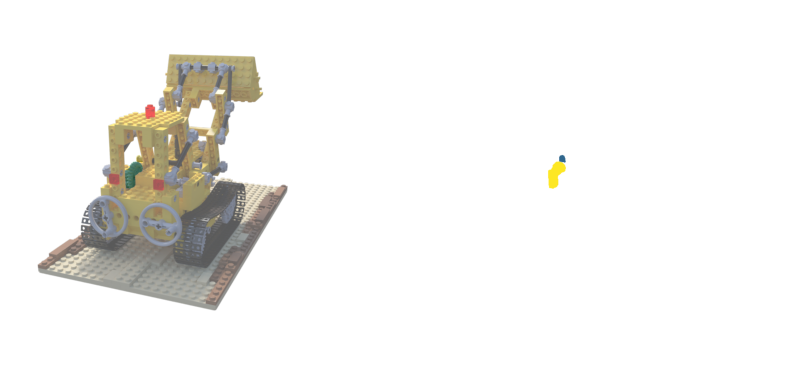

In [8]:
tree_data = tree_seg2.generate(
    image[..., :3],
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
for level, nodes in enumerate(tree_data.get_levels()):
    if level == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {level}, num={len(nodes)}:")
    plt.subplot(121)
    show_masks(image, tree_data.data['masks'][nodes - 1])
    plt.subplot(122)
    show_masks(None, tree_data.data['masks'][nodes - 1])
    plt.show()

In [ ]:
tree_data.save('results/temp.tree2d.pth')
t2 = TreeData()
t2.load('results/temp.tree2d.pth')
# tree_data.print_tree()
for level, nodes in enumerate(t2.get_levels()):
    if level == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {level}, num={len(nodes)}:")
    plt.subplot(121)
    show_masks(image, t2.data['masks'][nodes - 1])
    plt.subplot(122)
    show_masks(None, t2.data['masks'][nodes - 1])
    plt.show()

numpy((683, 1024, 3), uint8)
complete init segmentation
complete iter 0 update segmentation
complete iter 1 update segmentation
complete iter 2 update segmentation
complete iter 3 update segmentation
complete iter 4 update segmentation
complete iter 5 update segmentation
complete iter 6 update segmentation
complete iter 7 update segmentation
complete iter 8 update segmentation
complete iter 9 update segmentation
complete iter 10 update segmentation
complete iter 11 update segmentation
complete iter 12 update segmentation
complete iter 13 update segmentation
complete iter 14 update segmentation
complete iter 15 update segmentation
complete iter 16 update segmentation
complete iter 17 update segmentation
complete iter 18 update segmentation
complete iter 19 update segmentation
complete iter 20 update segmentation
complete iter 21 update segmentation
complete iter 22 update segmentation
complete iter 23 update segmentation
complete iter 24 update segmentation
complete iter 25 update segme

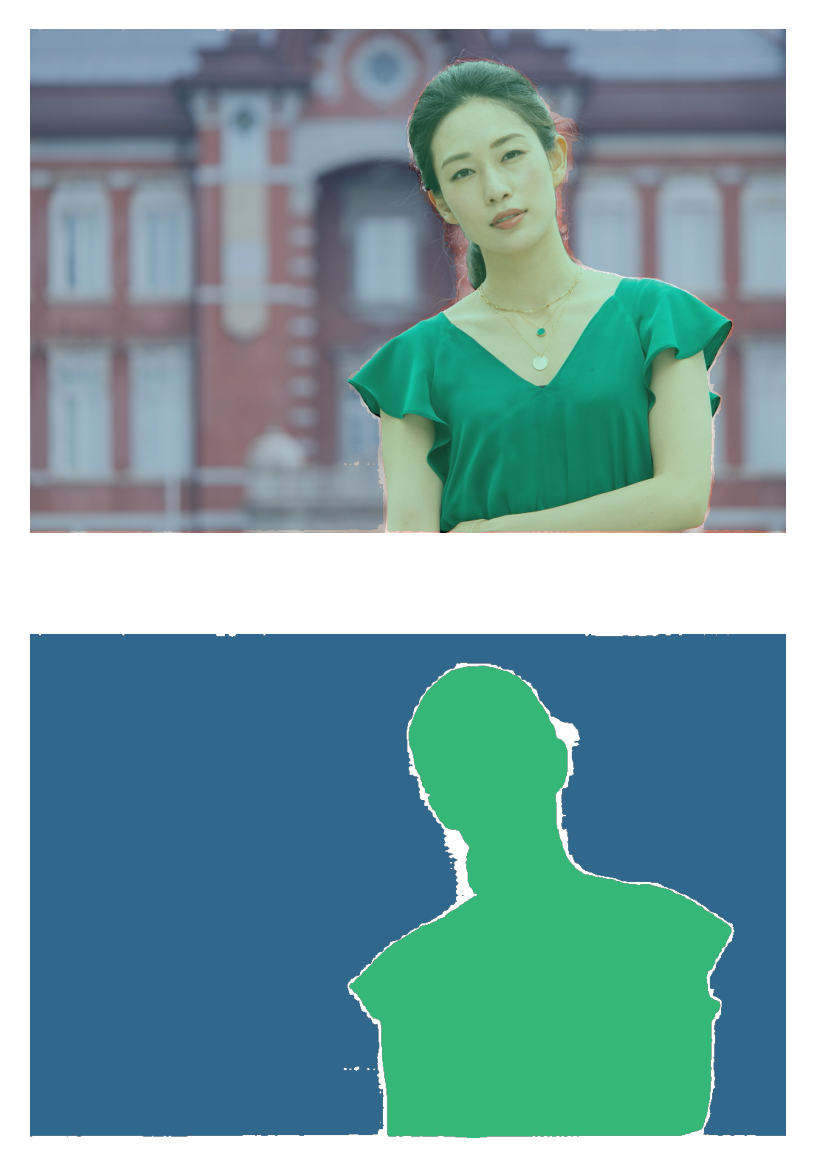

level 2, num=53: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]


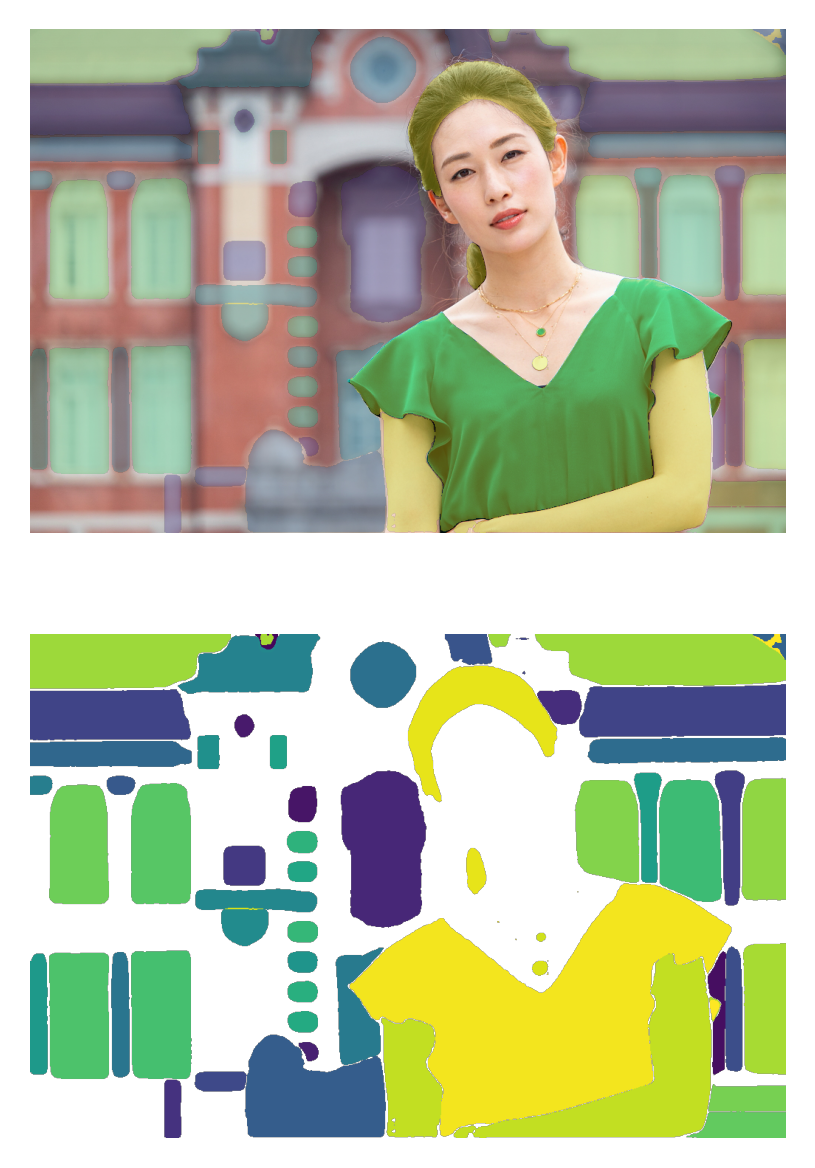

level 3, num=18: [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]


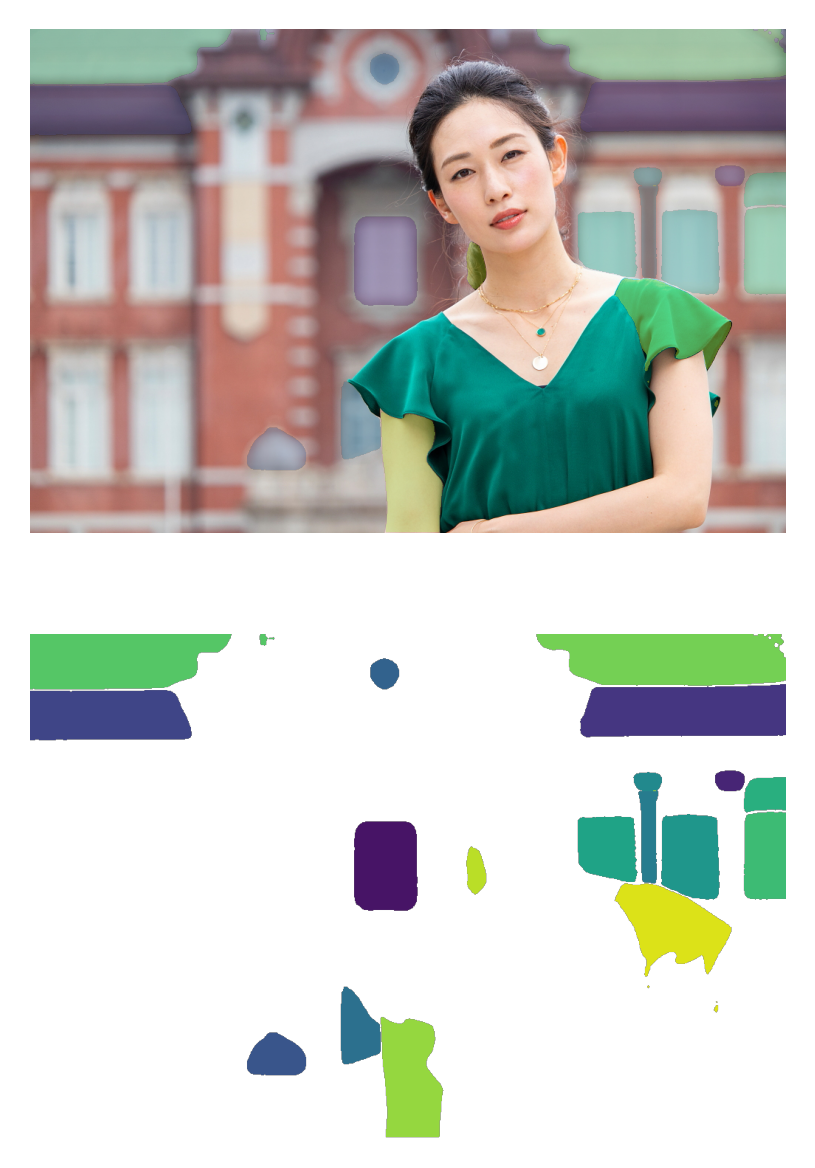

In [20]:
# load pictures
# img_path = Path('~/Pictures/cat_2.jpg').expanduser()
# img_path = Path('~/data/PartNet/my_render/14768_005.png').expanduser()
img_path = Path('~/Pictures/1.jpg').expanduser()
image = utils.load_image(img_path)
H, W = image.shape[:2]
print(utils.show_shape(image))

tree_data = tree_seg.generate(image[..., :3], max_iters=100, in_threshold=0.8, union_threshold=0.1)

for idx, level in enumerate(tree_data.get_levels()):
    if idx == 0:
        continue
    level = np.array(level) - 1
    plt.figure(dpi=300)
    print(f"level {idx}, num={len(level)}:", level)
    plt.subplot(211)
    show_masks(image, tree_data.data['masks'][level])
    plt.subplot(212)
    show_masks(None, tree_data.data['masks'][level])
    plt.show()

In [ ]:
plt.imshow(utils.load_image(img_path.with_name('14768_part_id_005.png')))
plt.axis('off')

In [ ]:
show_masks(None, tree_data['masks'][4])

In [ ]:
# load pictures
img_path = Path('~/Pictures/paddy/0001.jpg').expanduser()
image = utils.load_image(img_path)
H, W = image.shape[:2]
print(utils.show_shape(image))

tree_data = tree_seg.generate(
    image[..., :3], max_iters=10, in_threshold=0.8, union_threshold=0.1, filled_threshold=0.99
)

for idx, level in enumerate(tree_data.get_all_levels()):
    level = np.array(level) - 1
    plt.figure(figsize=(10, 5))
    print(f"level {idx}, num={len(level)}:", level)
    plt.subplot(121)
    show_masks(image, tree_data['masks'][level])
    plt.subplot(122)
    show_masks(None, tree_data['masks'][level])
    plt.show()

In [ ]:
show_masks(None, tree_data['masks'][3])

In [ ]:
points, unfilled_mask = tree_data.sample_first_unfill_level(10, 0.99)
# print(points.shape, points)
# points = np.array([[0.44, 0.4]])
tree_seg.predictor.set_image(image)
# tree_seg.stability_score_thresh = 0
# tree_seg.pred_iou_thresh = 0.5
# tree_seg.box_nms_thresh = 0
new_mask_data = tree_seg.process_points(points)
print(utils.show_shape({k: v for k, v in new_mask_data.items()}))

plt.figure(figsize=(15, 5))
plt.subplot(131)
show_masks(None, unfilled_mask)
plt.title('unfilled')
plt.subplot(132)
show_masks(image, new_mask_data['masks'])
plt.scatter(points[:, 0] * W, points[:, 1] * H, s=5, c='r')
plt.title('sampled points')
plt.subplot(133)
show_masks(None, new_mask_data['masks'])
plt.title('segmente results')
# plt.scatter(points[:, 0]*W, points[:, 1]*H, s=5)
plt.show()

#  3D Tree Segmentaion

In [ ]:
glctx = dr.RasterizeCudaContext()


@torch.no_grad()
def random_camera_pose(image_size=1024, num=1, radius_range=(2., 4.), elev_range=(0, 180), azim_range=(-180, 180)):
    radius = torch.rand(num, device=device) * (radius_range[1] - radius_range[0]) + radius_range[0]
    thetas = torch.rand(num, device=device) * (elev_range[1] - elev_range[0]) + elev_range[0]
    phis = torch.rand(num, device=device) * (azim_range[1] - azim_range[0]) + azim_range[0]

    fovy = math.radians(60)
    Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
    eye = ops_3d.coord_spherical_to(radius, thetas.deg2rad(), phis.deg2rad()).to(device)
    Tw2v = ops_3d.look_at(eye, torch.zeros_like(eye))
    Tv2w = ops_3d.look_at(eye, torch.zeros_like(eye), inv=True)
    Tw2c = Tv2c @ Tw2v
    return Tw2c, Tv2w


@torch.no_grad()
def render_mesh(mesh: Mesh, Tw2c: Tensor, Tv2w: Tensor, image_size=1024, light_location=(0, 2., 0.)):
    lights = ops_3d.PointLight(
        ambient_color=(0.6, 0.6, 0.6), diffuse_color=(2., 2., 2.), device=device, location=light_location
    )

    v_pos = ops_3d.xfm(mesh.v_pos, Tw2c)
    assert v_pos.ndim == 3, f"{v_pos.shape}, {Tw2c.shape}"
    rast, _ = dr.rasterize(glctx, v_pos, mesh.f_pos.int(), (image_size, image_size))
    points, _ = dr.interpolate(mesh.v_pos[None], rast, mesh.f_pos.int())
    # mask = rast[..., -1]>0
    # print(utils.show_shape(points, Tw2c))
    # z_w = ops_3d.xfm(points, Tw2c[:, None, :, :])
    # print(utils.show_shape(z_w, rast, mask))
    # print((rast[..., 2] - z_w[..., 2]/z_w[..., -1])[mask])
    uv, uv_da = dr.interpolate(mesh.v_tex[None], rast, mesh.f_tex.int())
    ka = dr.texture(mesh.material['ka'].data[..., :3].contiguous(), uv) if 'ka' in mesh.material else 0
    kd = dr.texture(mesh.material['kd'].data[..., :3].contiguous(), uv) if 'kd' in mesh.material else 0
    ks = dr.texture(mesh.material['ks'].data, uv) if 'ks' in mesh.material else 0

    nrm = ops_3d.compute_shading_normal(mesh, Tv2w[:, :3, 3], rast, None)
    view_direction = ops_3d.normalize(Tv2w[:, :3, 3])
    lights.location = view_direction
    images = ops_3d.Blinn_Phong(nrm, lights(points), view_direction, (ka, kd, ks))
    # images = ops_3d.Blinn_Phong(nrm, view_direction, view_direction, (ka, kd, ks))
    images = dr.antialias(images, rast, v_pos, mesh.f_pos.int())
    images = torch.where(rast[..., -1:] > 0, images, torch.ones_like(images))
    return images[0, :, :, :3], rast[0, :, :, -1].int()


In [ ]:
class Config:
    N_cycle = 100
    N_grid = 100
    N_uniform = 100
    box_nms_thresh = 0.7
    fovy = math.radians(60.)
    in_area_threshold = 50
    in_threshold = 0.9
    mesh = Path('/home/wan/data/meshes/tang_table/mesh_0_clean.obj')
    min_area = 100
    num_steps = 10

    radius_min = 2.0
    radius_max = 2.0
    theta_min = 30
    theta_max = 150
    phi_min = -30
    phi_max = 120.0

    points_per_batch = 64
    points_per_side = 32
    points_per_update = 256
    pred_iou_thresh = 0.88
    sam = Path('/home/wan/models/sam_vit_h_4b8939.pth')
    save_tree_data = True
    stability_score_thresh = 0.95
    union_threshold = 0.1


seg_3d = TreeSegment(Config(), sam=sam)
print(seg_3d.mesh)

In [ ]:
_, Tv2w = random_camera_pose(elev_range=(90 - 0, 90 - 0), azim_range=(90, 90), radius_range=(2, 2))
print(Tv2w.shape)
image, _ = seg_3d.render_mesh(Tw2v=Tv2w[0].inverse())
plt.figure(dpi=200)
plt.imshow(utils.as_np_image(image))
plt.axis('off')

In [ ]:
seg_3d.new_camera_pose(Tw2v=Tv2w[0].inverse())
seg_3d.autorun_tree_seg_2d()

for idx, nodes in enumerate(seg_3d.levels_2d):
    if idx == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {idx}, num={len(nodes)}:", nodes)
    plt.subplot(121)
    show_masks(seg_3d.image, seg_3d.tree2d.data['masks'][nodes - 1])
    plt.subplot(122)
    show_masks(None, seg_3d.tree2d.data['masks'][nodes - 1])
    plt.show()

In [ ]:
seg_3d.cfg.N_cycle = 100
seg_3d.run_tree_3d_cycle()

In [ ]:
seg_3d.cfg.N_uniform = 100
seg_3d.run_tree_3d_uniform()

In [ ]:
for idx, nodes in enumerate(seg_3d.levels_2d):
    if idx == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {idx}, num={len(nodes)}:", nodes)
    plt.subplot(121)
    show_masks(seg_3d.image, seg_3d.tree2d.data['masks'][nodes - 1])
    plt.subplot(122)
    show_masks(None, seg_3d.tree2d.data['masks'][nodes - 1])
    plt.show()

In [ ]:
seg_3d.reset_3d()

In [ ]:
seg_3d.run_tree_3d_load(0)
for idx, nodes in enumerate(seg_3d.levels_2d):
    if idx == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {idx}, num={len(nodes)}:", nodes)
    plt.subplot(121)
    show_masks(seg_3d.image, seg_3d.tree2d.data['masks'][nodes - 1])
    plt.subplot(122)
    show_masks(None, seg_3d.tree2d.data['masks'][nodes - 1])
    plt.show()

In [ ]:
image = seg_3d.rendering(Tw2v=seg_3d.Tw2v)
for idx, nodes in enumerate(seg_3d.levels_3d):
    if idx == 0:
        continue
    plt.figure(figsize=(10, 5))
    print(f"level {idx}, num={len(nodes)}:", nodes)
    masks = torch.stack([seg_3d.aux_data_3d[x.item()][0] for x in nodes], dim=0)
    plt.subplot(121)
    show_masks(image, masks)
    plt.subplot(122)
    show_masks(None, masks)
    plt.show()

In [ ]:
import xatlas

vmapping, indices, uvs = xatlas.parametrize(seg_3d.mesh.v_pos.cpu().numpy(), seg_3d.mesh.f_pos.cpu().numpy())
print(utils.show_shape(vmapping, indices, uvs))


In [ ]:
v_pos = torch.from_numpy(uvs).to(device) * 2 - 1  # [0, 1] --> [-1, 1]
v_pos = torch.cat([v_pos, torch.zeros_like(v_pos[:, :1]), torch.ones_like(v_pos[:, :1])], dim=-1)
f_pos = torch.from_numpy(indices.astype(np.int32)).to(device).int()
print('v_pos:', utils.show_shape(v_pos, f_pos))
rast, _ = dr.rasterize(glctx, v_pos[None], f_pos, (1024, 1024))


In [ ]:
# tri_id = seg_3d.compuate_uv(seg_3d.tri_id, num_adj=0)
tri_id = seg_3d.compuate_uv()
for idx, nodes in enumerate(seg_3d.levels_2d):
    if idx == 0:
        continue
    masks = []
    for mask_index in nodes:
        mask = torch.zeros_like(tri_id, dtype=torch.bool)
        for i in seg_3d.tri_id[seg_3d.tree2d.data['masks'][mask_index - 1]].unique():
            if i == 0:
                continue
            mask = mask | (tri_id == i)
        masks.append(mask)
    plt.figure(figsize=(20, 20), facecolor='black')
    plt.subplot(121)
    show_masks(None, *masks)
    plt.subplot(122)
    show_masks(seg_3d.image, seg_3d.tree2d.data['masks'][nodes - 1])

In [ ]:
mask_index = 20
tri_id_2 = seg_3d.compuate_uv(seg_3d.tri_id, seg_3d.tree2d.data['masks'][mask_index - 1], num_adj=2)
mask = torch.zeros_like(tri_id_2, dtype=torch.bool)
for i in seg_3d.tri_id[seg_3d.tree2d.data['masks'][mask_index - 1]].unique():
    # for i in selected_faces.unique() + 1:
    if i == 0:
        continue
    mask = mask | (tri_id_2 == i)
# mask = tri_id_2 > 0
plt.figure(figsize=(20, 20), facecolor='black')
plt.subplot(121)
show_masks(None, mask)
plt.subplot(122)
show_masks(seg_3d.image, seg_3d.tree2d.data['masks'][mask_index - 1])

# 测试

In [ ]:
cache_root = Path('~/wan_code/segmentation/segment_anything/results/12612b82ea88a8977007b330cacd9453').expanduser()
cache_data_filenames = sorted(list(cache_root.rglob('*.data')))
print(cache_data_filenames[0])
print(f"There are {len(cache_data_filenames)} cached data")

In [ ]:
data = torch.load(cache_data_filenames[0], map_location=device)
print(utils.show_shape(data))
show_masks(data['image'], data['tree_data']['masks'][1])

In [ ]:
masks = []
tri_ids = []
tri_index = []
num_masks = 0
for i in tqdm(range(len(cache_data_filenames))):
    # for i in range(10):
    data = torch.load(cache_data_filenames[i], map_location=device)
    num_masks += data['tree_data']['cnt']
    masks.append(data['tree_data']['masks'])
    tri_ids.append(data['tri_id'])
    tri_index.extend([i] * len(data['tree_data']['masks']))
masks = torch.cat(masks, dim=0)
tri_ids = torch.stack(tri_ids, dim=0)
tri_index = torch.tensor(tri_index, device=device)
print(utils.show_shape(masks, tri_ids, tri_index))
print(f'There are {num_masks} masks in total')

In [ ]:
threshold = 0.9
num_faces = seg_3d.mesh.f_pos.shape[0]


# step1: update nodes
def step_1(nodes):
    for i in tqdm(range(len(masks))):
        mask = masks[i]
        tri_id = tri_ids[tri_index[i]]  # type: Tensor
        index_i, counts_i = tri_id.unique(return_counts=True)
        # plt.imshow(color_mask(mask.cpu().numpy()))
        # plt.show()
        for j in mask.unique():
            j = j.item()
            if j == 0:
                continue
            mask_j = mask == j
            area_j = mask_j.sum().item()
            index_j, counts_j = tri_id[mask_j].unique(return_counts=True)
            is_in = False
            for n, node in enumerate(nodes):
                mask_n = node['sum'][tri_id]
                cnt_n = node['cnt'][tri_id]

                mask_new = (cnt_n == 0) & mask_j
                area_new = mask_new.sum().item()
                # inter_new = (mask_j & mask_new).sum().item()
                # iou_new = inter_new / (area_j + area_new - inter_new)
                iou_new = area_new / area_j

                mask_n = ((mask_n / cnt_n.clamp(1.)) > 0.5) | mask_new
                area_n = mask_n.sum().item()
                inter = (mask_j & mask_n).sum().item()
                iou = inter / (area_j + area_n - inter)

                if iou > threshold and iou_new < 0.5:
                    is_in = True
                    tmp_n = torch.zeros_like(node['sum'])
                    tmp_n[index_j] = counts_j.float()
                    tmp_n[index_i] /= counts_i.float()
                    tmp_n[0] = 0
                    node['sum'] += tmp_n
                    node['cnt'][index_i] += 1
                    node['items'].append((i, j))
                    # print('update', tri_index[i].item(), i, j)

            if not is_in:
                tmp_n = torch.zeros(num_faces + 1, dtype=torch.float32, device=device)
                tmp_n[index_j] = counts_j.float()
                tmp_n[index_i] /= counts_i.float()
                tmp_n[0] = 0
                cnt_n = torch.zeros(num_faces + 1, dtype=torch.int16, device=device)
                cnt_n[index_i] += 1
                cnt_n[0] = 1
                nodes.append({'sum': tmp_n, 'cnt': cnt_n, 'items': [(i, j)]})

In [ ]:
# step-2: update node attribute
def step_2(nodes):
    for node in tqdm(nodes):
        sum_new = torch.zeros_like(node['sum'])
        cnt_new = torch.zeros_like(node['cnt'])
        node['items'].clear()

        last_img_id = tri_index[0]
        tri_id = tri_ids[last_img_id]
        index_n, counts_n = tri_id.unique(return_counts=True)
        mask_n = node['sum'][tri_id]
        cnt_n = node['cnt'][tri_id]
        mask_n = mask_n / cnt_n.clamp(1.) > 0.5
        area_n = mask_n.sum().item()
        # node['items_'] = []
        for i in range(len(masks)):
            if last_img_id != tri_index[i]:
                last_img_id = tri_index[i]
                tri_id = tri_ids[last_img_id]
                index_n, counts_n = tri_id.unique(return_counts=True)
                mask_n = node['sum'][tri_id]
                cnt_n = node['cnt'][tri_id]
                mask_n = mask_n / cnt_n.clamp(1.) > 0.5
                area_n = mask_n.sum().item()
            mask = masks[i]
            for j in mask.unique():
                j = j.item()
                if j == 0:
                    continue
                mask_j = mask == j
                area_j = mask_j.sum().item()
                inter = (mask_j & mask_n).sum().item()
                iou = inter / (area_n + area_j - inter)
                # if iou > 0.3:
                #     plt.imshow(color_mask(mask_j * 2 + mask_n))
                #     plt.show()
                #     print('iou:', iou)
                if iou > threshold:
                    index_j, counts_j = tri_id[mask_j].unique(return_counts=True)
                    tmp_n = torch.zeros_like(node['sum'])
                    tmp_n[index_j] = counts_j.float()
                    tmp_n[index_n] /= counts_n.float()
                    tmp_n[0] = 0
                    sum_new += tmp_n
                    cnt_new += 1
                    node['items'].append((i, j))
                    # print(iou)
        node['faces'] = sum_new / cnt_new.clamp(1.) > 0.5
        # break

In [ ]:
nodes = []
step_1(nodes)
print([len(node['items']) for node in nodes])
step_2(nodes)
# step-3 update tree structure
nodes = sorted(nodes, key=lambda node: len(node['items']), reverse=True)
nodes = [node for node in nodes if len(node['items']) > 0]
print([len(node['items']) for node in nodes])
print(nodes[0])

In [ ]:
step_1(nodes)
print([len(node['items']) for node in nodes])
step_2(nodes)
nodes = sorted(nodes, key=lambda node: len(node['items']), reverse=True)
nodes = [node for node in nodes if len(node['items']) > 0]
print([len(node['items']) for node in nodes])
print(nodes[0])

In [ ]:
print(0.9 ** 6)